# Machinaal Leren - Sprint 2: Text Data

## Task:
What insights can we gain from the text data (title, description and reviews) ?

Possible tasks:
* Detect duplicate listings
* Extract keywords from reviews / descriptions
* Automatically make a list of positive and negative points for a listing based on the reviews
* Recognize listings from the same owner
* Detect anomalies (listings/ reviews that are very different from other listings/ reviews)
* Detect reviews that are very similar
* Perform sentiment analysis on a review
* ...

## Work table


|Task|Peter Bonnarens|Philip Kukoba|Lennert Franssens|
|------|------|------|------|
|Detect duplicate listings  |X  |X  | X |
|Extract keywords  |_  |_  | _ |
|Automatically make a list  |_  |_  | _ |
|Recognize listings from the same owner  |_  |_  | _ |
|Detect anomalies  |_  |_  | _ |
|Detect reviews that are very similar  |_  |_  | _ |
|Perform sentiment analysis on a review  |_  |_  | _ |

# **1 - LOADING THE DATASET**

In [18]:
%matplotlib inline

# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams
import nltk
import warnings
nltk.download('punkt')

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# delete warnings from output
warnings.filterwarnings('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the datasets into pandas dataframes
reviews = pd.read_csv("data/reviews.csv")
listings = pd.read_csv("data/listings.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,187870,540088,2011-09-17,1003634,Dominick,"This is a very lovely room. The room, bathroom..."
1,187870,581572,2011-09-29,178012,Nancy,Tamara's place in Ghent was really nice and cl...
2,187870,715167,2011-11-13,1391583,Charlotte,We spend one night at Tamara's and it was perf...
3,187870,834756,2012-01-03,1513484,Ger Y Flo,"Pasamos unos dias increibles en Gante, la habi..."
4,187870,855004,2012-01-10,1503813,Max,My girlfriend and I had the most wonderful tim...


In [20]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,...,4.58,4.85,NaN,t,1,0,1,0,3.61,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,...,4.49,4.54,NaN,f,2,2,0,0,2.84,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,...,4.97,4.63,NaN,f,2,2,0,0,0.29,NaN
3,216715,https://www.airbnb.com/rooms/216715,20210716195504,2021-07-16,converted loft,Please read full desription for how to get the...,It's close to all that you will want or need v...,https://a0.muscache.com/pictures/1927009/20760...,911466,https://www.airbnb.com/users/show/911466,...,4.89,4.76,NaN,t,1,1,0,0,4.31,NaN
4,252269,https://www.airbnb.com/rooms/252269,20210716195504,2021-07-16,Large & bright town House - Center Ghent - max 8p,"bright, spacious, authentic & beautifully rest...","our neighbourhood is quiet, but nicely vibrati...",https://a0.muscache.com/pictures/69675b54-3e78...,1195314,https://www.airbnb.com/users/show/1195314,...,4.98,4.72,NaN,f,1,1,0,0,2.23,NaN


Find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)

In [21]:
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

In [ ]:
listings.drop(['host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count','host_total_listings_count',
            'host_has_profile_pic','host_identity_verified','latitude','longitude','accommodates','bathrooms','bedrooms','beds','price','minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365',
            'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','license','instant_bookable','calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
            'reviews_per_month'], axis=1)

Drop all rows without comments.

In [23]:
reviews = reviews.dropna()
reviews_points = reviews.copy()
reviews_original = reviews.copy()

# Remove <b> tags and text in between it
reviews['comments'] = reviews['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
reviews['comments'] = reviews['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'<[^<>]*>', ' ', regex=True)

# Remove all special characters (non-word)
reviews['comments'] = reviews['comments'].str.replace(r'\W', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'[^\w\s\'\.\/]', '.', regex=True)

# Remove all single characters (like a floating 'b' after removing the HTML tags around it)
reviews['comments'] = reviews['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)

# Remove single characters at the start
reviews['comments'] = reviews['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)
#reviews_points['comments'] = reviews_points['comments'].str.replace(r'\^[a-zA-Z]\s+', ' ', regex=True)

# Substitute multiple spaces with a single space
reviews['comments'] = reviews['comments'].str.replace(r'\s+', ' ', regex=True)
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+', ' ', regex=True)

# Replace multiple dots with one dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\.+', '.', regex=True)

# Remove space(s) before dot
reviews_points['comments'] = reviews_points['comments'].str.replace(r'\s+\.', '.', regex=True)

# Convert to lowercase
reviews['comments'] = reviews['comments'].str.lower()
reviews_points['comments'] = reviews_points['comments'].str.lower()

In [24]:
# Remove <b> tags and text in between it
listings['description'] = listings['description'].str.replace(r'<b>.*?<\/b>', '', regex=True)

# Remove all HTML tags
listings['description'] = listings['description'].str.replace(r'<[^<>]*>', ' ', regex=True)

# Remove NaN values
listings = listings[listings['description'].notna()]

# To lowercase
listings["description"] = listings["description"].str.lower()

## **2 - DETECT DUPLICATE LISTINGS**

## Naive method
At first, detecting duplicate listings seems easy. We could try using a naive approach where we check if listings have the same description.

In [25]:
duplicates = listings[listings.duplicated(['description']) == True]

Let's take a look at some of these 'duplicates'

In [26]:
display(duplicates[duplicates.id.isin([17415990,17416223,17416437,17416518])])

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
241,17415990,https://www.airbnb.com/rooms/17415990,20210716195504,2021-07-16,Edville studio Duplex (2p-4p),studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/c556f91d-8b55...,414263,https://www.airbnb.com/users/show/414263,...,4.67,3.67,NaN,t,8,7,0,0.0,0.08,NaN
242,17416223,https://www.airbnb.com/rooms/17416223,20210716195504,2021-07-16,Edville studio Duplex A304 (2p-4p),studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/56f70957-aa6d...,414263,https://www.airbnb.com/users/show/414263,...,4.50,3.50,NaN,t,8,7,0,0.0,0.05,NaN
244,17416437,https://www.airbnb.com/rooms/17416437,20210716195504,2021-07-16,Edville Studio,studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/8719d90e-105b...,414263,https://www.airbnb.com/users/show/414263,...,4.78,4.22,NaN,t,8,7,0,0.0,0.24,NaN
245,17416518,https://www.airbnb.com/rooms/17416518,20210716195504,2021-07-16,Edville Studio,studio edville gent biedt verschillende studio...,Studio Edville Gent is gelegen aan het water i...,https://a0.muscache.com/pictures/352bf500-612e...,414263,https://www.airbnb.com/users/show/414263,...,4.58,4.25,NaN,t,8,7,0,0.0,0.28,NaN


We can see that these 4 listings share the same description. However, if we read the description we notice that these listings are spread over 2 different buildings. This indicates that these listings are not all the same listing but rather 2 separate listings that are both duplicated. 
If we take a look at the latitude/longitude we see that these listings share the same location, suggesting that these listings are in 1 building while the description says that there are 2 separate buildings. If we look at the price, we see that the prices of every listing here is different.

In conclusion: we have a hard time telling if these listings are duplicates or not. Let us first look at another example.

In [27]:
display(duplicates[duplicates.id.isin([42166580,42166739,42353100])])

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
674,42166580,https://www.airbnb.com/rooms/42166580,20210716195504,2021-07-16,Welcome in Ghent: private newly renovated house,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/9f1c93b3-1142...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN
675,42166739,https://www.airbnb.com/rooms/42166739,20210716195504,2021-07-16,Comfortable private modern house in the city,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/9ccb1f32-9833...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN
678,42353100,https://www.airbnb.com/rooms/42353100,20210716195504,2021-07-16,Cozy and private familyhouse in the city,our recently renovated house on 5 min from the...,"There is bus 3 around the corner, in 2 min you...",https://a0.muscache.com/pictures/ab6042c6-fa09...,36152908,https://www.airbnb.com/users/show/36152908,...,NaN,NaN,NaN,f,4,4,0,0.0,NaN,NaN


These 3 listings also share the same description. If we take a quick glance at the included picture_url, they have different links but all show the same photo. The names of the listings are different, but describe the same kind of listing. Maybe these listings really are duplicates?
If we look at the latitude/longitude, we notice that they are all slightly different... The prices of these listings are also different: €90 for the first and €120 for the other 2.

Again we have to conclude that it is hard to say that these listings are duplicates by only looking at the description, latitude/longitude, price, ...

## Trying to detect similar listings based on the descriptions

Let us simplify this problem and say that listings with the same description are very likely to be duplicates. This raises another problem: what if there are listings that have almost the same description but with a few different words? Simply checking if the descriptions are the same will return that these listings are not duplicates. In order to tackle this problem we will be using some modules from `Gensim`.

First, we only want to keep the 'id' and 'description' of our listings for this part.

In [ ]:
listings = listings[["id", "description"]]

Next, we noticed that our dataset contains listings in multiple languages. Before we continue we should detect what languages the descriptions are written in, and how many listings we have in each language. To do this, we will be using the `langdetect` library which supports 55 languages out of the box (link: https://pypi.org/project/langdetect/).

In [29]:
# To install the langdetect library, run this in your environment: python -m pip install langdetect
from langdetect import detect

description_languages = []
for description in listings["description"].values:
    try:
        description_languages.append(detect(description))
    except: #the detect function rarely fails, but when it does it can crash the for loop
        description_languages.append("unknown")

In [30]:
listings["language"] = description_languages
language_count_listings = listings.groupby(['language']).count()
print(language_count_listings)

           id  description
language                  
af          2            2
en        707          707
fr          2            2
nl        187          187


Here we see that most of the descriptions are written in english (~ 78%) or dutch (~ 21%). We will only be using the english descriptions since they represent the largest part of our dataset and most nlp models were intended to be used on the english language.

In [31]:
listings_english = listings[listings["language"] == "en"]
print(listings_english.shape)

(707, 3)


Now that we have our listings that we want, we can start preprocessing our data. We transform our pandas dataframe into a list of documents and apply some filters by using the `preprocessing`module from `Gensim`. These steps are inspired on this tutorial: https://towardsdatascience.com/a-laymans-guide-to-fuzzy-document-deduplication-a3b3cf9a05a7 .

In [110]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora
from gensim.similarities import Similarity
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

documents = listings_english["description"].to_list()
texts = [clean_text(doc) for doc in documents]

Next, we will use the word-level structures to train a Gensim n-graph phraser. A normal bigram generator would produce a bigram for each word pair. We will be using the `Phraser` module from Gensim, which is pretrained to select collocations or words that would commonly be found together. This will save program runtime by not storing a feature for every possible permutation of words. The `min_count` argument specifies how many times the phrase must be found in the corpus to be kept.

After training the Phraser, we use it to convert documents to collections of words/bigrams.

In [95]:
bigram = Phrases(texts, min_count=1)
bigram_phraser = Phraser(bigram)

texts_bigrams = [[text for text in bigram_phraser[ simple_preprocess(doc, deacc=True)]] for doc in documents]

To be able to use the Gensim module, we need to create a corpus and dictionary with some package-specific structure.

In [96]:
dictionary = corpora.Dictionary(texts_bigrams)
corpus = [dictionary.doc2bow(docString) for docString in texts_bigrams]

The dictionary maps each specific term to a unique ID. The corpus uses the dictionary we created to convert our original text documents to a numeric representation. Next, we create a similarity index to calculate the cosine similarity for our collection of document-term vectors. 

In [97]:
index = Similarity(corpus=corpus,
                   num_features=len(dictionary),
                   output_prefix='on_disk_output')

Now we can create a dictionary `similar_docs` which tracks each document and the similarity scores between it and all the other documents in the corpus.

In [98]:
doc_id = 0
similar_docs = {}
for similarities in index:
    similar_docs[doc_id] = list(enumerate(similarities))
    doc_id += 1

At last, we set a certain threshold that indicates how similar documents need to be before we consider them duplicates. This is a value that needs to be chosen (we set it at 0.9). Then we can loop over the `similar_docs` dictionary and store all the documents that pass the threshold in a new dictionary `duplicates`.

In [99]:
sim_threshold = 0.9
duplicates = {}
for doc_id, sim_doc_tuples in similar_docs.items():
    for sim_doc_tuple in sim_doc_tuples:
        sim_doc_id = sim_doc_tuple[0]
        sim_score = sim_doc_tuple[1]
        
        if sim_score >= sim_threshold and doc_id != sim_doc_id:
            if doc_id not in duplicates:
                duplicates[doc_id] = []
            duplicates[doc_id].append(sim_doc_id)

This dictionary now contains all the documents that our model considers duplicates. Let us take a look at the first element in the dictionary.

In [114]:
print(next(iter(duplicates.items())))

(9, [10, 15, 347])


We see that the document with id 9 has 3 other documents that are considered duplicates: 10, 15 and 347. If we print out these documents we see that they are almost completely identical, but a few words are different or certain sentences were left out. This means that if we had just checked if the descriptions were equal, we would not have found these duplicates.

In [100]:
print(documents[9])
print("-----")
print(documents[10])
print("-----")
print(documents[15])
print("-----")
print(documents[347])
print("-----")

this is a new self-catered studio situated in a hip upcoming neighbourhood of the center of ghent.  ideal for 1 person or couple.  erasmus or phd student.   with private kitchen and bathroom (shower, toilet, lavabo).  fully furnished and equipped kitchen.   this is a new self-catered studio in the center of ghent. windows in the front and the back.  fully equipped kitchen with fridge, combi-oven, ceramic hob and coffee machine.  the bathroom is equipped with lavabo, toilet and big shower 85 x 120.  the big desk makes it possible to do some office work. the studio remains always spacious because of the smart bed solution.  ideal for a touristic, educational or business stay for short or lang term.  please feel free to contact us if you have any questions   the studio is on the first floor.  there is a bike storage room on the ground floor. there ar 6 studio's in the building. two on 
-----
this is a new self-catered studio situated in a hip upcoming neighbourhood of the center of ghent.

## **3 - Keyword extraction**
### Keyword extraction from reviews using TF-IDF

To extract keywords from reviews, we first opt for TF-IDF. The term comes down to how many times a certain word occurs in a review (document), divided by the the number of reviews (documents) it occurs in.

Before running TF-IDF, we first have to detect the language of each review (since for example stop words are unique for a language). Be warned, the code below takes a while to compute.

In [16]:
# run this in your environment: python -m pip install langdetect

from langdetect import detect

all_languages = []
for review in reviews["comments"].values:
    try:
        all_languages.append(detect(review))
    except: #the detect func rarely fails, but when it does it can crash the for loop
        all_languages.append("unknown")
# all_languages

We add a column to our dataframe and look at the results.

In [17]:
reviews["language"] = all_languages
reviews["language"].value_counts().head()

en    27635
nl    11767
fr     6159
es     1989
de     1185
Name: language, dtype: int64

Most reviews are in English (en). We will keep only the English reviews since most libraries are optimal for English (eg stop words for tf-idf).

In [18]:
english_reviews = reviews[reviews["language"] == 'en']
english_reviews_copy = english_reviews.copy() #todo remove
english_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,187870,540088,2011-09-17,1003634,Dominick,this is very lovely room the room bathroom eve...,en
1,187870,581572,2011-09-29,178012,Nancy,tamara place in ghent was really nice and clea...,en
2,187870,715167,2011-11-13,1391583,Charlotte,we spend one night at tamara and it was perfec...,en
4,187870,855004,2012-01-10,1503813,Max,my girlfriend and had the most wonderful time ...,en
5,187870,897168,2012-02-01,581462,Eva,we had lovely stay with tamara and anna in ghe...,en
...,...,...,...,...,...,...,...
50910,50207003,398977730778256896,2021-07-04,5275569,Mathias,great appartement in nice part of the city lov...,en
50911,50297619,401873565247888378,2021-07-08,408597262,Nacho,amazing and spacious flat good location and ve...,en
50915,50431051,394711577334590933,2021-06-28,347114686,Mandy,nathalie loft is incredible very open space wi...,en
50916,50475480,398328411988280868,2021-07-03,399018965,Kevin,the place is neat and the system to go there i...,en


We set-up the CountVectorizer and TfidTransformer properly for TF-IDF.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#todo optimise?
count_vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,   
    max_df=0.5
)

X_train_counts = count_vect.fit_transform(english_reviews["comments"])

tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts) # is a matrix

X_train_tf   # matrix of #entries x #words(features)

<27635x65077 sparse matrix of type '<class 'numpy.float64'>'
	with 964482 stored elements in Compressed Sparse Row format>

We will add a column to our DataFrame with the top 5 keywords for this comment based on TF-IDF.

In [20]:
import re
import heapq

feature_names=count_vect.get_feature_names()

top_5_keywords_column = []
i = 0 
for review in english_reviews["comments"]: 

    # numpy array troubles to find the indices and tf-idf values, using regex
    np_arr = np.array(X_train_tf[i])
    np_arr_str = str(np_arr)
    arr = np_arr_str.split("\n")
    feature_indices = []
    feature_values = []
    j = 0
    for el in arr:
        try:
            regex_result = re.search(r"  \(\d, (\d*)\)\t(\d\.\d*)", el)
            feature_indices.append(regex_result.group(1))
            feature_values.append(regex_result.group(2))
        except:
            break
        j += 1
     
    top_5_tf_idf_indices = heapq.nlargest(5, range(len(feature_values)), feature_values.__getitem__)
    
    top_5_keywords = []
    for ind in top_5_tf_idf_indices:   
        true_index = int(feature_indices[ind])
        top_5_keywords.append(feature_names[true_index])
    
    top_5_keywords_column.append(top_5_keywords)   
    i += 1
    
english_reviews["top_5_keywords"] = top_5_keywords_column

english_reviews[["comments","top_5_keywords"]]

,comments,top_5_keywords
0,this is very lovely room the room bathroom eve...,"[touch helpful, hosts touch, helpful absolutel..."
1,tamara place in ghent was really nice and clea...,"[tamara, tamara briefly, pitcher, met tamara, ..."
2,we spend one night at tamara and it was perfec...,"[tamara perfect, tamara, infos city, host gent..."
4,my girlfriend and had the most wonderful time ...,"[tamara, perfect tamara, location spent, time ..."
5,we had lovely stay with tamara and anna in ghe...,"[tamara anna, tamara, anna, city live, ghent w..."
...,...,...
50910,great appartement in nice part of the city lov...,"[loved interior, appartement nice, great appar..."
50911,amazing and spacious flat good location and ve...,"[location helpful, amazing spacious, spacious ..."
50915,nathalie loft is incredible very open space wi...,"[rain showers, sharing space, thanks sharing, ..."
50916,the place is neat and the system to go there i...,"[ll recommend, place neat, recommend sure, eff..."


Looking at the output above, the results are pretty good. Consider the rows 1 to 5 where 'tamara' is an important keyword. This is logical since the host name is highly unique for these reviews of a host.

### Keyword extraction using word embeddings
For the next part we will try a more advanced technique, word embeddings. A word is mapped to a point in a high dimensional space, where words with similar meanings are mapped to nearby points. This opens the door for discovering more complex relationships and it turns text in a numerical form that deep neural networks can understand. We will use the word embedding technique of Word2Vec. We will use the skip-gram approach, where words are predicted in a certain range before and after the current word in the same sentence.

For this we use the Word2Vec implementation by gensim.

## TODO UITLEG HOE WORD2VEC GENSIM WERKT

Before training a word2vec model we need to adjust the input data to a 'list of lists' model.

In [21]:
listoflists = [row.split(" ") for row in english_reviews["comments"]]
listoflists[:2] #print examples

[['this',
  'is',
  'very',
  'lovely',
  'room',
  'the',
  'room',
  'bathroom',
  'everything',
  'was',
  'very',
  'clean',
  'the',
  'location',
  'very',
  'good',
  'walking',
  'distance',
  'from',
  'most',
  'touristic',
  'sights',
  'the',
  'guests',
  'anneke',
  'en',
  'tamara',
  'were',
  'great',
  'hosts',
  'always',
  'in',
  'touch',
  'and',
  'very',
  'helpful',
  'absolutely',
  'recommend',
  ''],
 ['tamara',
  'place',
  'in',
  'ghent',
  'was',
  'really',
  'nice',
  'and',
  'clean',
  'and',
  'had',
  'everything',
  'we',
  'needed',
  'for',
  'short',
  'stay',
  'comfortable',
  'bed',
  'towels',
  'etc',
  'even',
  'though',
  'we',
  'only',
  'met',
  'tamara',
  'briefly',
  'she',
  'was',
  'super',
  'friendly',
  'and',
  'helpful',
  'giving',
  'us',
  'maps',
  'and',
  'city',
  'guides',
  'and',
  'even',
  'leaving',
  'us',
  'fresh',
  'pitcher',
  'of',
  'water',
  'and',
  'chocolate',
  'almonds',
  'on',
  'our',
  'arri

We train a word2vec model. sg=1 means we use skip gram instead of CBOW. 
TODO expand

In [22]:
from gensim.models import Word2Vec

model = Word2Vec(listoflists, workers=3, window =3, sg = 1)

We test our model:

In [23]:
model.wv.most_similar(positive=["loft"])

[('apartment', 0.7867975234985352),
 ('flat', 0.7364221811294556),
 ('townhouse', 0.7341452240943909),
 ('apt', 0.7203496098518372),
 ('cottage', 0.7005760073661804),
 ('studio', 0.6990193724632263),
 ('duplex', 0.6848702430725098),
 ('attic', 0.6828580498695374),
 ('apartement', 0.677619993686676),
 ('house', 0.6759755611419678)]

The model gives a logical output. Similar words to loft are other types of housing.

## **4 - LISTING POSITIVE AND NEGATIVE POINTS FROM REVIEWS**

### Import packages

In [24]:
# run this in your environment: python -m pip install textblob
import nltk
#nltk.download('punkt')
from textblob import TextBlob

### Apply TextBlob

In [25]:
reviews_points['comments'] = reviews_points['comments'].apply(TextBlob)

In [26]:
#for index, row in reviews_points.iterrows():
#    comment = row.comments
#    positive = []
#    negative = []
#    for sentence in comment.sentences:
#        if sentence.sentiment.polarity < -0.3:
#            negative.append(str(sentence).replace('.', ''))
#        elif sentence.sentiment.polarity > 0.3:
#            positive.append(str(sentence).replace('.', ''))
#    print("\n----- COMMENT -----")
#    print("listing_id: ", row.listing_id)
#    print("comment: ", comment)
#    print("positive points: ", positive)
#    print("negative points: ", negative)

# **5 - TOPIC MODELING**

References:
* https://towardsdatascience.com/customer-reviews-analysis-using-nlp-the-netflix-use-case-92b3645770e1
* https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* https://stackoverflow.com/questions/40278023/how-do-i-print-lda-topic-model-and-the-word-cloud-of-each-of-the-topics
* https://neptune.ai/blog/latent-dirichlet-allocation-lda-tutorial-topic-modeling

### Import packages

In [27]:
# run this in your environment: python -m pip install pyLDAvis
# run this in your environment: python -m pip install wordcloud

import gensim
import pickle
import os
import os.path

import gensim.parsing.preprocessing as gsp
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from gensim import utils
from nltk.tokenize import word_tokenize
from gensim import corpora
from wordcloud import WordCloud

### Data (text) cleaning
How does the dataset look like.

In [28]:
review_topics = english_reviews_copy.copy()

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We only need some references and the comment of a review. So we can drop the date, reviewer_id and reviewer_name.

In [29]:
review_topics = review_topics.drop(['date', 'reviewer_id', 'reviewer_name', 'language'], axis=1)
review_topics.head()

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,listing_id,id,comments
0,187870,540088,this is very lovely room the room bathroom eve...
1,187870,581572,tamara place in ghent was really nice and clea...
2,187870,715167,we spend one night at tamara and it was perfec...
4,187870,855004,my girlfriend and had the most wonderful time ...
5,187870,897168,we had lovely stay with tamara and anna in ghe...


Now we need to do some cleaning to remove numerics, stop words, short words and do stemming. To do that we make a function and make use of the gensim module to do the actual cleaning.

In [30]:
filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
review_topics['comments'] = review_topics['comments'].map(lambda x: clean_text(x))

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Latent Dirichlet allocation (LDA)

In [32]:
review_topics['comments'] = review_topics['comments'].apply(word_tokenize)
review_topics['comments']

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        [love, room, room, bathroom, clean, locat, goo...
1        [tamara, place, ghent, nice, clean, need, shor...
2        [spend, night, tamara, perfect, hous, nice, co...
4        [girlfriend, wonder, time, tamara, home, larg,...
5        [love, stai, tamara, anna, ghent, welcom, prov...
                               ...                        
50910          [great, appart, nice, citi, love, interior]
50911       [amaz, spaciou, flat, good, locat, help, host]
50915    [nathali, loft, incred, open, space, lot, ligh...
50916           [place, neat, effici, ll, recommend, sure]
50917    [michiel, help, respond, quickli, offer, advic...
Name: comments, Length: 27635, dtype: object

In [33]:
folder = "gensim"
os.chdir(".")
if not os.path.isdir(folder):
    os.mkdir(folder)


dictionary = corpora.Dictionary(review_topics['comments'])
corpus = [dictionary.doc2bow(text) for text in review_topics['comments']]
pickle.dump(corpus, open('./gensim/corpus.pkl', 'wb'))
dictionary.save('./gensim/dictionary.gensim')

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = gensim.models.ldamodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


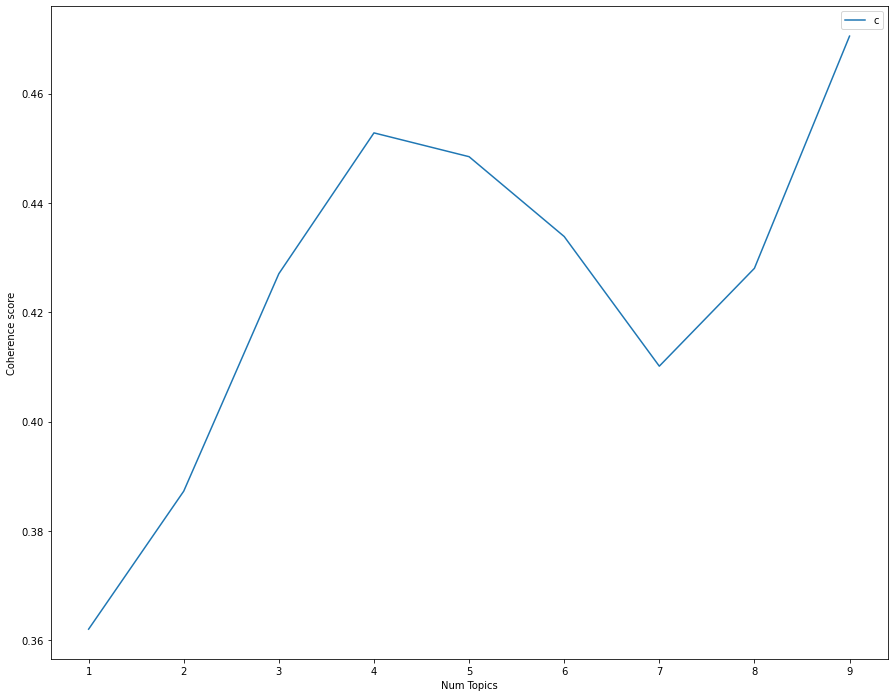

In [35]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=review_topics['comments'], start=1, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
NUM_TOPICS = 7
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('./gensim/model.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.066*"locat" + 0.060*"great" + 0.057*"apart" + 0.045*"stai" + 0.040*"place" + 0.032*"recommend" + 0.031*"clean" + 0.026*"perfect" + 0.023*"ghent" + 0.018*"host"')
(1, '0.051*"center" + 0.051*"citi" + 0.050*"walk" + 0.032*"close" + 0.026*"place" + 0.024*"nice" + 0.024*"station" + 0.023*"centr" + 0.022*"minut" + 0.018*"locat"')
(2, '0.070*"nice" + 0.069*"room" + 0.048*"hous" + 0.037*"place" + 0.036*"clean" + 0.032*"host" + 0.032*"stai" + 0.024*"good" + 0.022*"recommend" + 0.019*"friendli"')
(3, '0.060*"great" + 0.054*"place" + 0.038*"host" + 0.037*"stai" + 0.030*"recommend" + 0.029*"locat" + 0.025*"nice" + 0.023*"help" + 0.018*"friendli" + 0.018*"appart"')
(4, '0.020*"walk" + 0.018*"ghent" + 0.017*"love" + 0.015*"restaur" + 0.014*"park" + 0.012*"apart" + 0.011*"space" + 0.010*"lot" + 0.010*"coffe" + 0.010*"bar"')
(5, '0.040*"stai" + 0.035*"home" + 0.029*"place" + 0.023*"host" + 0.020*"airbnb" + 0.019*"best" + 0.017*"feel" + 0.016*"time" + 0.016*"like" + 0.015*"dai"')
(6, '0.016*"be

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


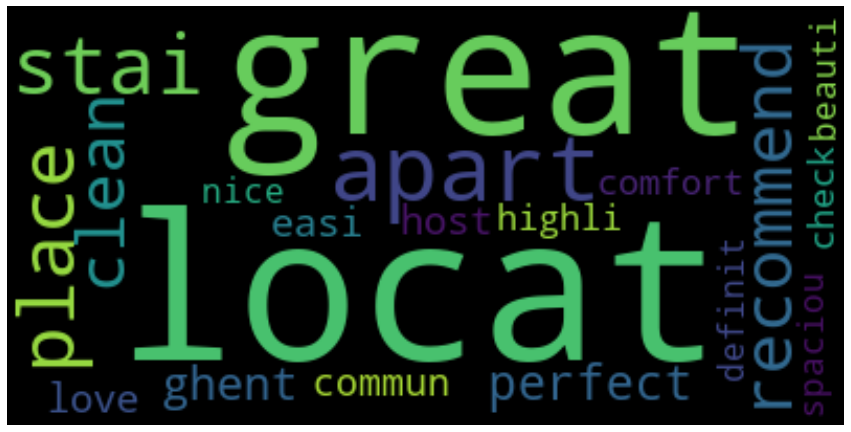

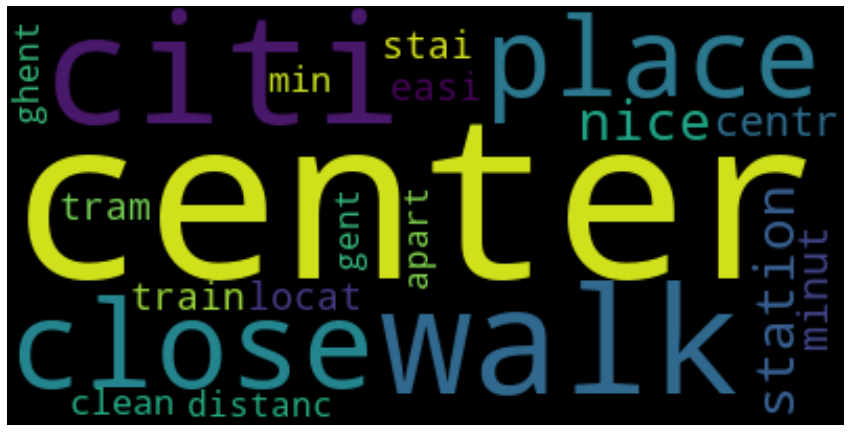

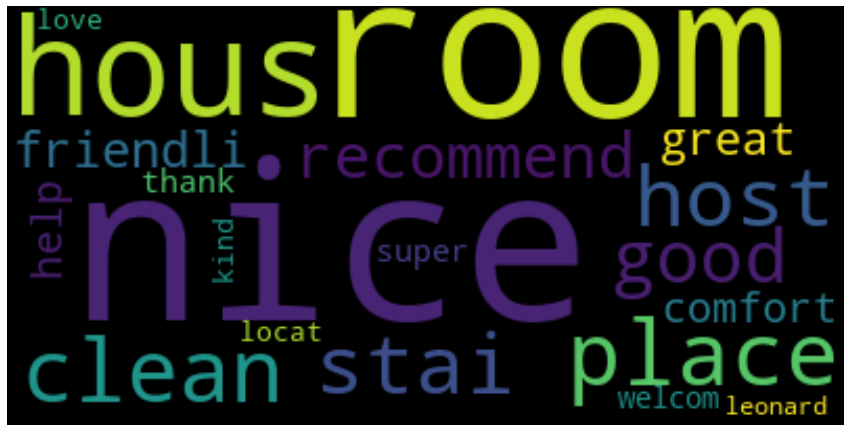

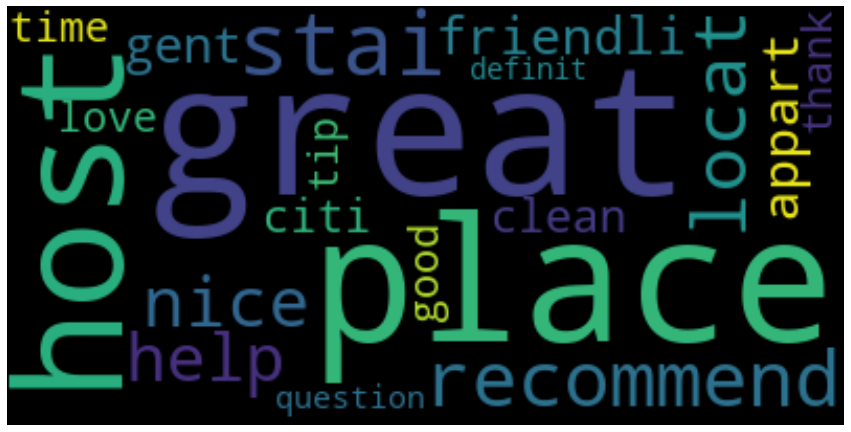

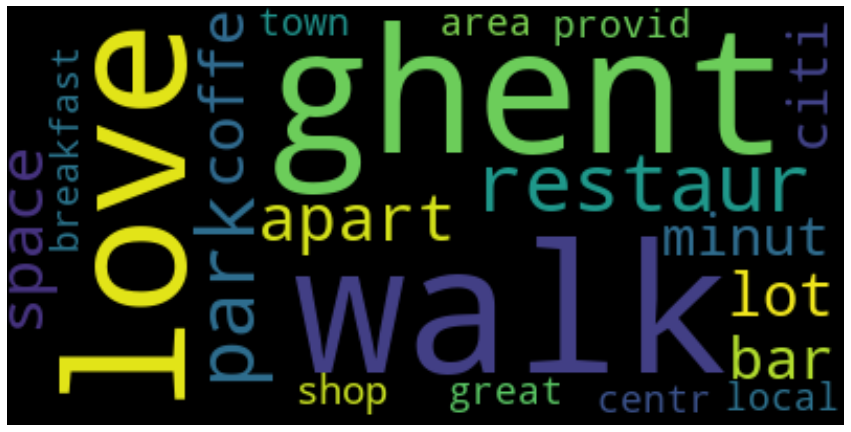

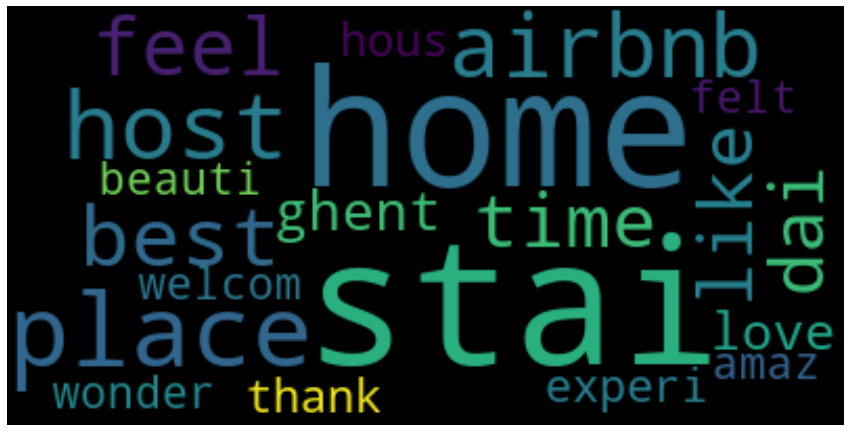

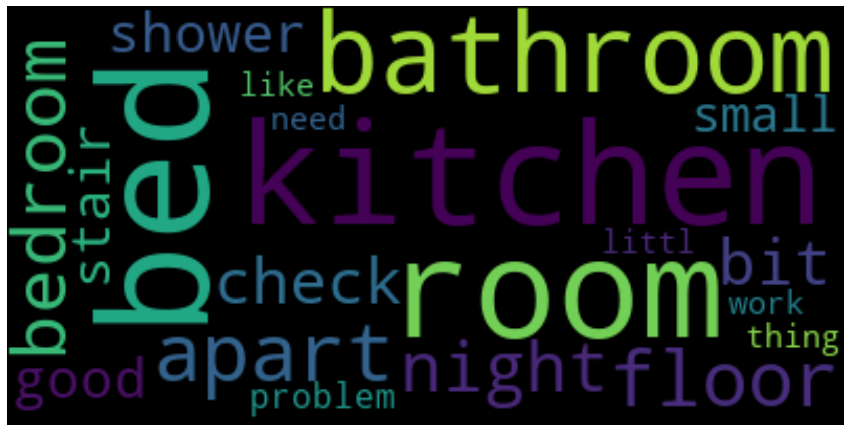

In [37]:
for t in range(ldamodel.num_topics):
    wordcloud = WordCloud().fit_words(dict(ldamodel.show_topic(t,20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Each circle corresponds to a topic. The distance between the topics shows how different they are. We have divided the reviews into 3 topics. We can see which words are the most used ones in each topic. These can also be seen in the above wordclouds.

In [38]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, corpus, dictionary)
vis

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.127071 -0.076414       1        1  17.514669
6     -0.279711  0.109290       2        1  16.714947
1      0.004323 -0.221881       3        1  15.973925
4     -0.181555 -0.126312       4        1  15.370795
5      0.005078  0.198977       5        1  12.543791
3      0.180376  0.013737       6        1  11.568441
2      0.144417  0.102604       7        1  10.313434, topic_info=       Term          Freq         Total Category  logprob  loglift
14     room   5481.000000   5481.000000  Default  30.0000  30.0000
50   center   4848.000000   4848.000000  Default  29.0000  29.0000
42     nice   9813.000000   9813.000000  Default  28.0000  28.0000
7     great  13280.000000  13280.000000  Default  27.0000  27.0000
19     walk   6557.000000   6557.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
12     love    672.169620   6035.709746   Topic7  -4.5102   0.0768
58  perfect    574.198139   5074.979024   Topic7  -4.6677   0.0926
11    locat    668.142128  11819.642995   Topic7  -4.5162  -0.6013
22   beauti    481.235020   3803.235810   Topic7  -4.8443   0.2045
95    enjoi    418.846898   2589.218783   Topic7  -4.9832   0.4501

[491 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11099      7  0.984258   agnör
484        2  0.132054  airbnb
484        5  0.867214  airbnb
1112       2  0.038417    airi
1112       4  0.952733    airi
...      ...       ...     ...
150        2  0.779197    work
150        3  0.079433    work
150        5  0.141214    work
10381      3  0.976919  xavier
10718      7  0.981044    yana

[837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 5, 6, 4, 3])

# **7 - SENTIMENT ANALYSIS**

The goal of sentiment analysis is trying to classify reviews as either positive or negative based on the words in the review. Scikit-learn has a great tutorial on working with textual data that we will follow (link: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

These are the steps that we will follow:
* First, we will write a text classification pipeline to classify reviews as either positive or negative.
* Then, we will search for a good set of parameters to use by using grid search.
* Lastly, we will evaluate the performance on a held out test set.

## Extracting features from reviews

First, we would need to turn the text content into numerical feature vectors. The most intuitive way to do so is to use a 'bags of words' representation. In scikit-learn this is possible by using the `CountVectorizer` module which converts a collection of text documents to a matrix of token counts. Instead of using the occurence count (which has the issue that longer documents will have higher average count values than shorter documents, even though they might talk about the same topics) we should be downscaling by using tf-idf. This is handled with the `TfidfTransformer` module. Luckily for us, all these steps were already done in section 3 - Extracting keywords from reviews using TF-IDF, so we will be reusing it.

## Training a classifier



In [39]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, english_reviews.comments)

D:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MemoryError: Unable to allocate 5.62 GiB for an array with shape (27635, 27273) and data type int64

## Evaluation of the performance on the test set

## Parameter tuning using grid search

# **7 BIS - LENNERTS APPROACH FOR SENTIMENT ANALYSIS**

# Sentiment analysis on words

## Import Packages

In [ ]:
# run this in your environment: python -m pip install pandas_profiling

import nltk
import re
import unicodedata
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

st_words=set(stopwords.words('english'))

## Cleaning

In [ ]:
review_word_sentiments = english_reviews_copy.copy()

In [ ]:
def basic_clean(text):
  
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
words = basic_clean(''.join(str(review_word_sentiments['comments'].tolist())))

In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:12]

In [ ]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
def sentiment(text):
    senti =TextBlob(text)
    return senti.sentiment

review_word_sentiments['polarity'] = review_word_sentiments['comments'].apply(sentiment).apply(lambda x: x[0])

review_word_sentiments.head(10)

In [ ]:
def categories(pol):
    if pol>0.01:
        return 'positive'
    else:
        return 'negative'
    
review_word_sentiments['pd_sentiment'] = review_word_sentiments['polarity'].apply(categories)
review_word_sentiments.head(10)

In [ ]:
pos_riv = review_word_sentiments[review_word_sentiments['pd_sentiment']=='positive']
pos_riv = pos_riv[pos_riv['polarity'] > 0.2]
pos_riv.drop('pd_sentiment', axis=1)

neg_riv = review_word_sentiments[review_word_sentiments['pd_sentiment']=='negative']
neg_riv = neg_riv[neg_riv['polarity'] < 0]
neg_riv.drop('pd_sentiment', axis=1)

In [ ]:
all_positive = " ".join(pos_riv['comments'])

po_wcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_positive)

plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT POSITIVE WORDS",fontdict={'color':"green",'fontsize':19})
plt.imshow(po_wcloud,interpolation='bilinear')
plt.show()

In [ ]:
all_negative = " ".join(neg_riv['comments'])

neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_negative)

plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEGATIVE WORDS",fontdict={'color':'red','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

# **8 - SIMILAR REVIEWS**

Reference: https://medium.datadriveninvestor.com/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8

## Import Packages

In [ ]:

# run this in your environment: python -m pip install gensim

from gensim import utils
import gensim.parsing.preprocessing as gsp


from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cosine

## Data cleaning


Now we need to do some cleaning to remove numerics, stop words, short words and do stemming. To do that we make a function and make use of the gensim module to do the actual cleaning.

In [ ]:
review_similarity = english_reviews_copy.copy()
review_similarity = review_similarity.drop(['date', 'reviewer_id', 'reviewer_name', 'language'], axis=1)

In [ ]:
filters = [
           gsp.strip_tags,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords,
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
review_similarity['comments'] = review_similarity['comments'].map(lambda x: clean_text(x))
review_similarity.shape[0]

In [ ]:
review_similarity['split_count'] = review_similarity['comments'].apply(lambda x: len(x.split()))
review_similarity = review_similarity[(review_similarity['split_count'] > 7)]
review_similarity = review_similarity.drop(['split_count'], axis=1)
review_similarity.shape[0]

## Convert text to Vector Space Model

We use Doc2Vec as Vector Space Model because it trains a neural network internally. This gives numerical vector representations of the text.

The class below is a transformer which converts comments into document vectors.

In [ ]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['comments']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['comments']).split())
                                     for index, row in df_x.iterrows()]))


Now we apply it to all the comments (this prints 20 results). The vector size is set to 300 so that each comment has 300 numerical features.

In [ ]:
comments = review_similarity.copy()
comments = comments.drop(['listing_id', 'id'], axis=1)

doc2vec_tr = Doc2VecTransformer(vector_size=150, learning_rate=0.1, epochs=20)
doc2vec_tr.fit(comments)
doc2vec_vectors = doc2vec_tr.transform(comments)

## Training Auto-Encoder Neural Network


Let the Auto Encoder Neural Network (deep non-linear regressor) work on the doc2vec data.

In [ ]:
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 300,
                                                 75, 
                                                 300,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

Now we can see the accuracy of the Auto Encoder Neural Network.

In [ ]:

auto_encoder.score(predicted_vectors, doc2vec_vectors)

And find now the most similar reviews.

In [ ]:
def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))
    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Listing id and review id:', review_similarity.iloc[index, 0], review_similarity.iloc[index, 1])  
        print('Cosine Sim Val :', consine_sim_val)
        comment_row = reviews_original[reviews_original['id'] == review_similarity.iloc[index, 1]]
        print('Comment :', str(comment_row['comments'].iloc[0]))
        print('---------------------------------')

In [ ]:

sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors, reverse=True)
print('Top 20 anomaly reviews')
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities, n=20)